In [93]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

Timeframe and Tickers

In [94]:
years = 10

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', ]

Download Adjusted close prices

In [95]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

C:\Users\mannk\AppData\Local\Temp\ipykernel_22356\2349071396.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_22356\2349071396.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_22356\2349071396.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_22356\2349071396.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s

                   SPY        BND         GLD         QQQ
Date                                                     
2015-12-21  171.428116  60.779800  103.150002  103.420273
2015-12-22  172.983704  60.697311  102.610001  104.100113
2015-12-23  175.125824  60.704853  102.309998  104.873077
2015-12-24  174.836761  60.749992  103.050003  104.854469
2015-12-28  174.437286  60.749992  102.269997  104.798607
...                ...        ...         ...         ...
2025-12-10  687.570007  74.260002  389.049988  627.609985
2025-12-11  689.169983  74.260002  393.239990  625.580017
2025-12-12  681.760010  74.029999  395.440002  613.619995
2025-12-15  680.729980  74.120003  395.799988  610.539978
2025-12-16  678.869995  74.260002  395.890015  611.750000

[2512 rows x 4 columns]


Calculate Log returns

In [96]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ
Date                                              
2015-12-22  0.009033 -0.001358 -0.005249  0.006552
2015-12-23  0.012307  0.000124 -0.002928  0.007398
2015-12-24 -0.001652  0.000743  0.007207 -0.000177
2015-12-28 -0.002287  0.000000 -0.007598 -0.000533
2015-12-29  0.010615 -0.003099 -0.000685  0.015607
...              ...       ...       ...       ...
2025-12-10  0.006610  0.002967  0.004250  0.004087
2025-12-11  0.002324  0.000000  0.010712 -0.003240
2025-12-12 -0.010810 -0.003102  0.005579 -0.019303
2025-12-15 -0.001512  0.001215  0.000910 -0.005032
2025-12-16 -0.002736  0.001887  0.000227  0.001980

[2511 rows x 4 columns]


Creating Equally weighted portfolio and calculating Historicaal returns

In [97]:
portfolio_value = 100000
weights = np.array([1/len(tickers)] * len(tickers))

historical_returns = (log_returns * weights).sum(axis=1)

print(weights)
print(historical_returns)

[0.25 0.25 0.25 0.25]
Date
2015-12-22    0.002245
2015-12-23    0.004225
2015-12-24    0.001530
2015-12-28   -0.002605
2015-12-29    0.005609
                ...   
2025-12-10    0.004479
2025-12-11    0.002449
2025-12-12   -0.006909
2025-12-15   -0.001105
2025-12-16    0.000340
Length: 2511, dtype: float64


X-day Historical Returns

In [98]:
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()
historical_x_day_returns = historical_x_day_returns.dropna()
print(historical_x_day_returns)

Date
2015-12-29    0.011005
2015-12-30    0.002959
2015-12-31   -0.006317
2016-01-04   -0.013322
2016-01-05   -0.009716
                ...   
2025-12-10    0.003803
2025-12-11    0.006611
2025-12-12   -0.001041
2025-12-15    0.000118
2025-12-16   -0.000746
Length: 2507, dtype: float64


Covariance Matrix and Portfolio Standard Deviation

In [99]:
cov_matrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

print(portfolio_std_dev)

0.11202111411773341


VaR at different Confidence levels

In [100]:
confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = -portfolio_value * (norm.ppf(1-cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $  2,256.11
    95%:          $  2,829.37
    99%:          $  3,904.71


Distribution of Portfolio returns and Parametric VaR estimates

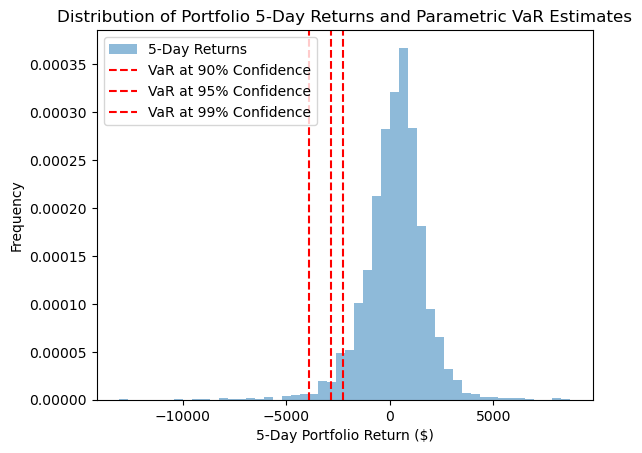

In [101]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()

Parametric ES

In [102]:
ESs = []

mean_daily = historical_returns.mean()

for cl in confidence_levels:
    z = norm.ppf(1 - cl)
    pdf = norm.pdf(z)

    ES = portfolio_value * (
        (pdf / (1 - cl)) * portfolio_std_dev * np.sqrt(days / 252)
        - mean_daily * days
    )

    ESs.append(ES)

print(f'{"Confidence":<15} {"VaR ($)":<15} {"ES ($)":<15}')
print('-' * 45)

for cl, VaR, ES in zip(confidence_levels, VaRs, ESs):
    print(f'{cl*100:>6.0f}%{"":<7} {VaR:>12,.0f} {ES:>15,.0f}')

Confidence      VaR ($)         ES ($)         
---------------------------------------------
    90%               2,256           2,535
    95%               2,829           3,021
    99%               3,905           3,972


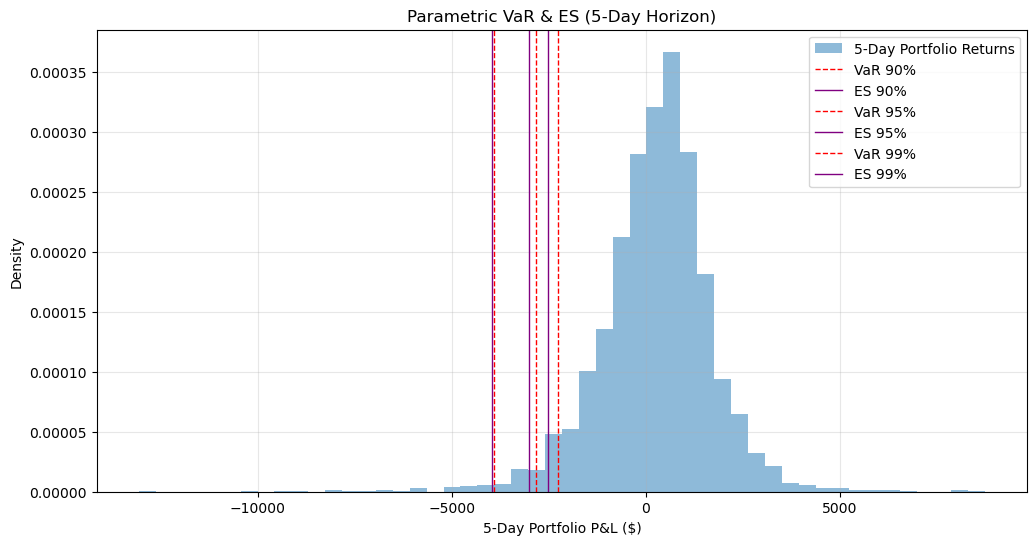

In [103]:
# Convert rolling returns to dollar P&L
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(12, 6))

# Histogram
plt.hist(
    historical_x_day_returns_dollar,
    bins=50,
    density=True,
    alpha=0.5,
    label=f'{days}-Day Portfolio Returns'
)

# Plot VaR & ES lines
for cl, VaR, ES in zip(confidence_levels, VaRs, ESs):
    plt.axvline(
        x=-VaR,
        linestyle='--',
        color='red',
        linewidth=1,
        label=f'VaR {int(cl*100)}%'
    )
    
    plt.axvline(
        x=-ES,
        linestyle='-',
        color='purple',
        linewidth=1,
        label=f'ES {int(cl*100)}%'
    )

plt.xlabel(f'{days}-Day Portfolio P&L ($)')
plt.ylabel('Density')
plt.title(f'Parametric VaR & ES ({days}-Day Horizon)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


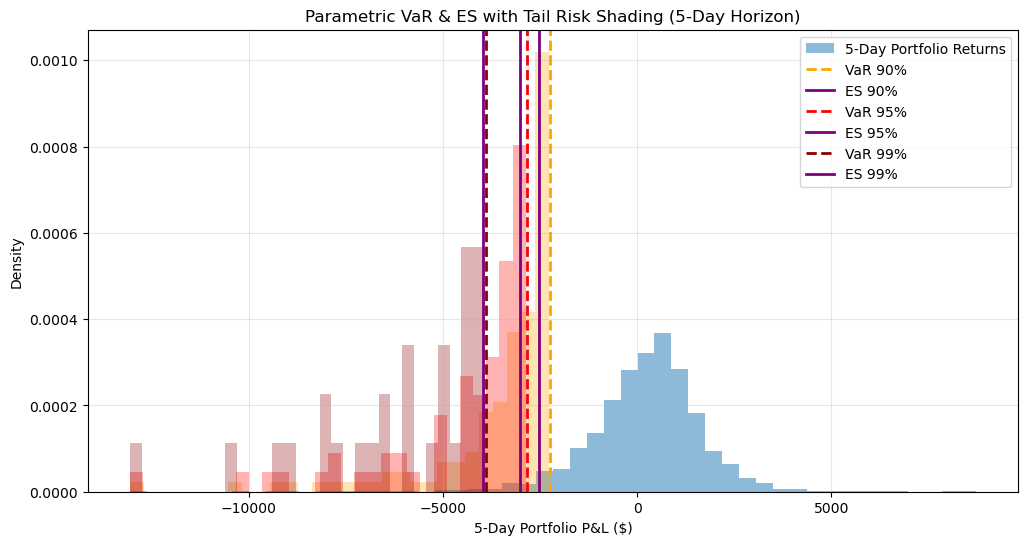

In [104]:
# Convert rolling returns to dollar P&L
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(12, 6))

# Histogram
plt.hist(
    historical_x_day_returns_dollar,
    bins=50,
    density=True,
    alpha=0.5,
    label=f'{days}-Day Portfolio Returns'
)

# Colors for VaR by confidence level
var_colors = {
    0.90: 'orange',
    0.95: 'red',
    0.99: 'darkred'
}

# Plot VaR, ES, and shade tail region
for cl, VaR, ES in zip(confidence_levels, VaRs, ESs):
    
    # VaR line (colored, dashed)
    plt.axvline(
        x=-VaR,
        linestyle='--',
        linewidth=2,
        color=var_colors[cl],
        label=f'VaR {int(cl*100)}%'
    )
    
    # ES line (purple, solid)
    plt.axvline(
        x=-ES,
        linestyle='-',
        linewidth=2,
        color='purple',
        label=f'ES {int(cl*100)}%'
    )
    
    # Shade tail losses beyond VaR
    tail_losses = historical_x_day_returns_dollar[
        historical_x_day_returns_dollar <= -VaR
    ]
    
    plt.hist(
        tail_losses,
        bins=30,
        density=True,
        alpha=0.3,
        color=var_colors[cl]
    )

plt.xlabel(f'{days}-Day Portfolio P&L ($)')
plt.ylabel('Density')
plt.title(f'Parametric VaR & ES with Tail Risk Shading ({days}-Day Horizon)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Historical VaR for comparison

In [105]:
confidence_interval = 0.95
Historical_VaR = -np.percentile(historical_x_day_returns,100 - (confidence_interval * 100))*portfolio_value

z = norm.ppf(1 - confidence_interval)

Parametric_VaR = -portfolio_value * (
    z * portfolio_std_dev * np.sqrt(days / 252)
    - historical_returns.mean() * days
)

print(f'Parametric VaR: ${VaR_95:,.2f}')

print(f'Historical VaR: ${Historical_VaR:,.2f}')

Parametric VaR: $2,829.91
Historical VaR: $2,208.58


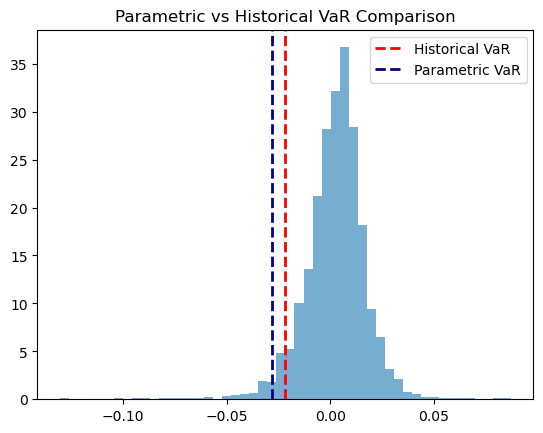

In [106]:
plt.hist(historical_x_day_returns, bins=50, density=True, alpha=0.6)

plt.axvline(
    -Historical_VaR / portfolio_value,
    linestyle='--',
    linewidth=2,
    color='red',
    label='Historical VaR'
)

plt.axvline(
    -Parametric_VaR / portfolio_value,
    linestyle='--',
    linewidth=2,
    color='darkblue',
    label='Parametric VaR'
)

plt.legend()
plt.title('Parametric vs Historical VaR Comparison')
plt.show()


In [110]:
confidence_levels = [0.90, 0.95, 0.99]

Historical_ESs = []

for cl in confidence_levels:
    # Historical VaR in returns
    hist_var_return = np.percentile(
        historical_x_day_returns,
        100 * (1 - cl)
    )
    
    # Tail losses beyond VaR
    tail_returns = historical_x_day_returns[
        historical_x_day_returns <= hist_var_return
    ]
    
    # Historical ES in dollar terms
    hist_es = -tail_returns.mean() * portfolio_value
    Historical_ESs.append(hist_es)


In [111]:
print(f'{"Confidence":<12} {"Hist ES ($)":<18} {"Param ES ($)":<18}')
print('-' * 50)

for cl, hES, pES in zip(confidence_levels, Historical_ESs, ESs):
    print(f'{int(cl*100):>6}%{"":<5} {hES:>15,.0f} {pES:>18,.0f}')


Confidence   Hist ES ($)        Param ES ($)      
--------------------------------------------------
    90%                2,646              2,535
    95%                3,534              3,021
    99%                6,353              3,972


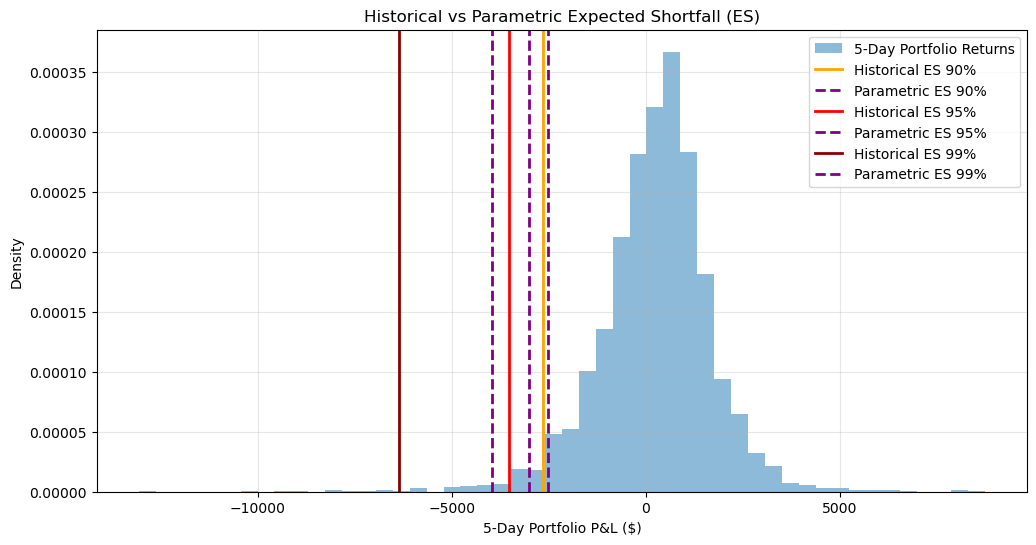

In [112]:
plt.figure(figsize=(12, 6))

# Histogram of dollar P&L
plt.hist(
    historical_x_day_returns_dollar,
    bins=50,
    density=True,
    alpha=0.5,
    label=f'{days}-Day Portfolio Returns'
)

# Colors
colors = {0.90: 'orange', 0.95: 'red', 0.99: 'darkred'}

for cl, hES, pES in zip(confidence_levels, Historical_ESs, ESs):
    
    # Historical ES
    plt.axvline(
        x=-hES,
        linestyle='-',
        linewidth=2,
        color=colors[cl],
        label=f'Historical ES {int(cl*100)}%'
    )
    
    # Parametric ES
    plt.axvline(
        x=-pES,
        linestyle='--',
        linewidth=2,
        color='purple',
        label=f'Parametric ES {int(cl*100)}%'
    )

plt.xlabel(f'{days}-Day Portfolio P&L ($)')
plt.ylabel('Density')
plt.title('Historical vs Parametric Expected Shortfall (ES)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
